In [1]:
import torch

from Modules import LoadingModule
from Modules import Features_encoder
from Modules import quantizationModule
from Modules import wav2vec_transformer
from Modules import ContrastiveLoss

from Modules import TempLibriSpeech

In [2]:
"""

#data loader module init
StandardScalerTransform = LoadingModule.StandardScalerTransform
LargeDataModule = LoadingModule.LargeDataModule("./data/Librispeech", batch_size=16, num_workers=1, transform=StandardScalerTransform)
"""

'\n\n#data loader module init\nStandardScalerTransform = LoadingModule.StandardScalerTransform\nLargeDataModule = LoadingModule.LargeDataModule("./data/Librispeech", batch_size=16, num_workers=1, transform=StandardScalerTransform)\n'

In [3]:
#Temp import dataloader ### rendre compatible PLightning quand on aura le GPU
# en attendant import manuel
from torch.utils.data import DataLoader



dataset = TempLibriSpeech.LibriSpeech(split="train-clean-100", target_length=16000, device='cuda')
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
for i, (audio, text) in enumerate(data_loader):
    print(f"Exemple {i+1}")
    print(f"Audio shape: {audio.shape}")
    print(f"Texte: {text}")
    print("-" * 50)
    if i == 1: 
        break

Exemple 1
Audio shape: torch.Size([16, 16000])
Texte: ('THE FACTOR THAT UNDERLIES ALL THE PERPLEXITIES AND MOST OF THE CONTENTMENT OF MARRIAGE IS ITS UNIQUE DEGREE OF CONCENTRATED INTIMACY HERE THE SUPREME TESTING ALWAYS COMES EACH MEANS SO MUCH TO THE OTHER', "YOUR HONOUR REPLIED THE CORPORAL KNOWS OF TOM'S MISFORTUNES BUT THIS AFFAIR HAS NOTHING TO DO WITH THEM ANY FURTHER THAN THIS", "YES I SUPPOSE IT'S SO WELL SENATOR BALLOON PUT FIFTEEN CENTS WORTH OF STAMPS ON EACH OF THOSE SEVEN HUGE BOXES OF OLD CLOTHES AND SHIPPED THAT TON OF SECOND HAND RUBBISH OLD BOOTS AND PANTALOONS AND WHAT NOT THROUGH THE MAILS AS REGISTERED MATTER", 'I IMAGINED THAT THEY WOULD BE DISGUSTED UNTIL', "BUT PIERCED BY ONE ONLY THE MOTTO BEING SHE ALONE THE HEART WAS MADE OF A SINGLE RUBY AS BIG AS AN OSTRICH'S EGG", 'STAY COUNT HE ADDED YOU WHO MAY BE CALLED THE EMPEROR IF I CLAIM THE TITLE OF KING OF FINANCE HAVE YOU MANY PIECES OF PAPER OF THIS SIZE EACH WORTH A MILLION', 'MISTER WILMINGTON AND MISSUS MUNG

In [5]:
### Model dev ###

In [6]:
import torch
import torch.nn as nn

class Model_W2V(nn.Module):
    def __init__(self, embed_size, num_heads, dropout, forward_expansion, kernel_size, groups, d_model, num_layers, max_relative_position):

        #EAB
        self.batch_size = batch_size
        #self.seq_length = seq_length
        self.embed_size = embed_size
        self.mask_prob = 0.50
        self.mask_length = 10
        self.num_heads = num_heads
        self.dropout = dropout
        self.forward_expansion = forward_expansion
        self.kernel_size = kernel_size
        self.groups = groups
        self.d_model = d_model
        self.num_layers = num_layers

        self.num_codebooks = 2
        self.num_codes = 320
        
        self.code_dim = 256
        self.output_dim = 512
        self.temperature= 0.05

        self.max_relative_position = max_relative_position

        super(Model_W2V, self).__init__()

        

        self.FeaturesEncoder = Features_encoder.FeatureEncoder(input_channels=1, feature_dim=512) #1501 ?
        self.masking = wav2vec_transformer.MaskingWithLearnableEmbedding()
        # d_model, num_heads, dropout, forward_expansion):

        #embed_size, num_heads, dropout, forward_expansion,max_relative_position):
        self.TranformerBlock = wav2vec_transformer.TransformerBlockW(self.embed_size, self.num_heads, self.dropout, self.forward_expansion, self.max_relative_position)   #(self.embed_size, self.num_heads, self.dropout, self.forward_expansion, self.kernel_size, self.groups, self.d_model, self.max_relative_position)
        self.quantization = quantizationModule.QuantizationModule(
            input_dim=512,  # Should match feature_dim from FeatureEncoder
            codebook_size=self.num_codes,
            num_codebooks=self.num_codebooks,
            output_dim=self.output_dim,
            temperature=self.temperature
        )

        # (K , k temp, G codevectorgroup, Vcodevectorpergroup, a 0,05)
        
        self.LossItem = ContrastiveLoss.Wav2vec2Loss(K=100,k=self.temperature, G=self.num_codebooks, V = self.num_codes, a=0.05)
        

    
    def forward(self, x):


       # print("ORIGINAL , ", x.shape)
        x = x.to(next(self.parameters()).device)
        x = x.unsqueeze(1)

        x = self.FeaturesEncoder(x)
        
       #
        
        
        # print("q",x.shape)
        
        quantized_repr, diversity_loss = self.quantization(x)
        
        masked_reps, mask = self.masking(x, self.mask_prob, self.mask_length) #(self, x, mask_prob, mask_length)
        
        contextualized_reps = self.TranformerBlock(masked_reps, masked_reps, masked_reps, mask)
                                                # value, key, query, mask=None
        

        #print("Debug", contextualized_reps.shape, quantized_repr.shape, mask.shape)
        
        
        # context_repr, quantized_repr, perplexity, time_mask_indices):

        
        loss = self.LossItem(contextualized_reps, quantized_repr, diversity_loss, mask)
        
        # print("Context Representation shape:", contextualized_reps.shape)
        # print("Quantized Representation shape:", quantized_repr.shape)
        # print("Mask Indices shape:", masked_reps.shape)
        # mask = torch.tensor(mask)
        # print("Unique Mask Indices values:", mask.unique())

        
   # embed_size, num_heads, dropout, forward_expansion, kernel_size, groups,d_model
        
        return x, contextualized_reps, loss
    

In [7]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm


loss_123 = []

def train_model(model, dataset, epochs, learning_rate, device):

    dataloader = DataLoader(dataset, batch_size=model.batch_size, shuffle=True)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    for epoch in range(epochs):
        
        epoch_loss = 0
        total_loss = 0.0

        num_batches = len(dataloader) - 1

        for batch_idx, (inputs, _) in enumerate(tqdm( data_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            
            if batch_idx >= num_batches:
                print("break")
                break  # S'arrêter avant la dernière itération

            optimizer.zero_grad()
            
            _,_, loss = model(inputs)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            total_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{num_batches}], Loss: {loss.item():.4f}")
                loss_123.append(loss.item())
                
        avg_loss = total_loss / num_batches
        print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")

    return loss_123


In [21]:
batch_size = 16
seq_length = 151
embed_size = 512
num_heads = 8
dropout = 0.0
forward_expansion = 1024
kernel_size = 7
groups = 2
d_model = 512
num_layers = 12

max_relative_position=128
torch.autograd.set_detect_anomaly(True)

device = 'cuda'#torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model_W2V(embed_size, num_heads, dropout, forward_expansion, kernel_size, groups, embed_size, num_layers, max_relative_position).to(device)


loss_123 = train_model(model, dataset, epochs=1, learning_rate=5e-4, device=device)


Epoch 1/1:   0%|          | 1/1784 [00:01<58:03,  1.95s/it]

Epoch [1/1], Step [1/1783], Loss: 6.0160


Epoch 1/1:   6%|▌         | 101/1784 [02:23<40:02,  1.43s/it]

Epoch [1/1], Step [101/1783], Loss: 5.7218


Epoch 1/1:  11%|█▏        | 201/1784 [04:42<37:01,  1.40s/it]

Epoch [1/1], Step [201/1783], Loss: 5.7110


Epoch 1/1:  17%|█▋        | 301/1784 [07:05<35:07,  1.42s/it]

Epoch [1/1], Step [301/1783], Loss: 5.7143


Epoch 1/1:  22%|██▏       | 401/1784 [09:26<32:33,  1.41s/it]

Epoch [1/1], Step [401/1783], Loss: 5.7120


Epoch 1/1:  28%|██▊       | 501/1784 [11:48<29:17,  1.37s/it]

Epoch [1/1], Step [501/1783], Loss: 5.7156


Epoch 1/1:  34%|███▎      | 601/1784 [14:08<27:47,  1.41s/it]

Epoch [1/1], Step [601/1783], Loss: 5.7093


Epoch 1/1:  39%|███▉      | 701/1784 [16:26<25:14,  1.40s/it]

Epoch [1/1], Step [701/1783], Loss: 5.7140


Epoch 1/1:  45%|████▍     | 801/1784 [18:47<22:00,  1.34s/it]

Epoch [1/1], Step [801/1783], Loss: 5.7119


Epoch 1/1:  51%|█████     | 901/1784 [21:13<22:27,  1.53s/it]

Epoch [1/1], Step [901/1783], Loss: 5.7193


Epoch 1/1:  56%|█████▌    | 1001/1784 [23:34<18:42,  1.43s/it]

Epoch [1/1], Step [1001/1783], Loss: 5.7052


Epoch 1/1:  62%|██████▏   | 1101/1784 [25:54<16:12,  1.42s/it]

Epoch [1/1], Step [1101/1783], Loss: 5.7144


Epoch 1/1:  67%|██████▋   | 1201/1784 [28:14<13:16,  1.37s/it]

Epoch [1/1], Step [1201/1783], Loss: 5.7047


Epoch 1/1:  73%|███████▎  | 1301/1784 [30:35<10:59,  1.37s/it]

Epoch [1/1], Step [1301/1783], Loss: 5.7112


Epoch 1/1:  79%|███████▊  | 1401/1784 [32:56<09:08,  1.43s/it]

Epoch [1/1], Step [1401/1783], Loss: 5.7174


Epoch 1/1:  84%|████████▍ | 1501/1784 [35:19<06:47,  1.44s/it]

Epoch [1/1], Step [1501/1783], Loss: 5.7085


Epoch 1/1:  90%|████████▉ | 1601/1784 [37:41<04:15,  1.40s/it]

Epoch [1/1], Step [1601/1783], Loss: 5.7154


Epoch 1/1:  93%|█████████▎| 1656/1784 [39:00<03:00,  1.41s/it]


KeyboardInterrupt: 

In [ ]:
name = '28dec_15epochs_train3'

model_path = f"./models/training-breakpoint/{name}.pth"


torch.save(model.state_dict(), model_path)

name_loss = f'loss_{name}'
array_path = f"./models/training-breakpoint/{name_loss}.npy"

np.save(array_path, loss_123)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

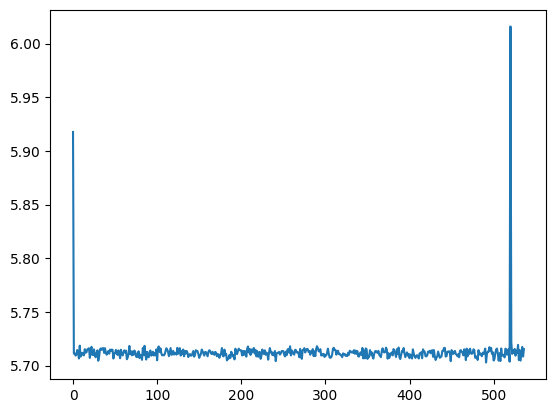

In [23]:
plt.plot(loss_123)